<a href="https://colab.research.google.com/github/worldwidekatie/DS-Unit-2-Applied-Modeling/blob/master/module1-define-ml-problems/LS_DS_231_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 3, Module 1*

---


# Define ML problems

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your decisions.

- [ ] Choose your target. Which column in your tabular dataset will you predict?
- [ ] Is your problem regression or classification?
- [ ] How is your target distributed?
    - Classification: How many classes? Are the classes imbalanced?
    - Regression: Is the target right-skewed? If so, you may want to log transform the target.
- [ ] Choose your evaluation metric(s).
    - Classification: Is your majority class frequency >= 50% and < 70% ? If so, you can just use accuracy if you want. Outside that range, accuracy could be misleading. What evaluation metric will you choose, in addition to or instead of accuracy?
    - Regression: Will you use mean absolute error, root mean squared error, R^2, or other regression metrics?
- [ ] Choose which observations you will use to train, validate, and test your model.
    - Are some observations outliers? Will you exclude them?
    - Will you do a random split or a time-based split?
- [ ] Begin to clean and explore your data.
- [ ] Begin to choose which features, if any, to exclude. Would some features "leak" future information?

If you haven't found a dataset yet, do that today. [Review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2) and choose your dataset.

Some students worry, ***what if my model isn't “good”?*** Then, [produce a detailed tribute to your wrongness. That is science!](https://twitter.com/nathanwpyle/status/1176860147223867393)

## First read in the dataset and stuff

[GitHub showing how I created this dataframe today ](https://github.com/worldwidekatie/Build_Week_2/blob/master/Data_Frame_Creation.ipynb)

In [0]:
import pandas as pd
df_orig = pd.read_csv('https://raw.githubusercontent.com/worldwidekatie/Build_Week_2/master/Final_IRA.csv')

In [2]:
df = df_orig[['content',	'region',	'language',	'publish_date',	'harvested_date',	
             'following',	'followers',	'updates',	'post_type',	'account_type',	
             'new_june_2018',	'retweet',	'account_category']]
df.head()

,content,region,language,publish_date,harvested_date,following,followers,updates,post_type,account_type,new_june_2018,retweet,account_category
0,#adee RT davis1988will: Congratulations for Ma...,United States,English,7/30/2017 21:18,7/30/2017 21:18,995,313,332,QUOTE_TWEET,Right,0,1,RightTroll
1,RT SSOL getting attention. It's penny play day...,United States,English,6/27/2015 21:47,6/27/2015 21:48,7,35,2213,NaN,Commercial,1,0,Commercial
2,#laup SHOCK VIDEO : Antifa Thugs Break a Latin...,Unknown,English,8/17/2017 2:20,8/17/2017 2:21,36,6,793,NaN,Right,0,0,RightTroll
3,PROOF Melania Has Done FAR MORE for Disaster R...,Unknown,English,9/2/2017 3:09,9/2/2017 3:09,4984,925,3411,NaN,Right,0,0,RightTroll
4,"An USC professor, Raphael Bostic, named first ...",United States,English,3/15/2017 22:00,3/15/2017 22:00,14207,17561,3852,NaN,left,0,0,LeftTroll


## Choose your target. Which column in your tabular dataset will you predict?

In [64]:
#I'm going to choose retweet
df['retweet'].value_counts()

0    6310
1    4336
Name: retweet, dtype: int64

## Is your problem regression or classification?

In [0]:
#It is classification

## How is your target distributed?
* Classification: How many classes? Are the classes imbalanced?

In [43]:
df['retweet'].value_counts(normalize=True)

0    0.592711
1    0.407289
Name: retweet, dtype: float64

## Choose your evaluation metric(s).
* Classification: Is your majority class frequency >= 50% and < 70% ? If so, you can just use accuracy if you want. Outside that range, accuracy could be misleading. What evaluation metric will you choose, in addition to or instead of accuracy?

In [0]:
#I may use accuracy since 59% is between 50% and 70%
#But I'd like to experiment with precision and recall

## Choose which observations you will use to train, validate, and test your model.
* Are some observations outliers? 
* Will you exclude them?
* Will you do a random split or a time-based split?

In [0]:
#I will do a time-based split for test since
#The dataset has a natural split for June 2018
#It will show how well the model works for future data
#But will use random split for train and validate

In [3]:
train = df[(df['new_june_2018'] == 0)]
test = df[(df['new_june_2018'] == 1)]
train.shape, test.shape

((9380, 13), (1266, 13))

In [4]:
from sklearn.model_selection import train_test_split
import numpy as np
train, val = train_test_split(train, random_state=42)
train.shape, val.shape

((7035, 13), (2345, 13))

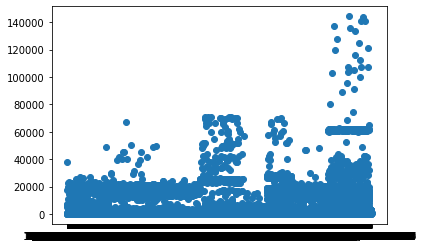

In [55]:
import matplotlib.pyplot as plt
plt.scatter(df['publish_date'], df['followers'])
plt.show();

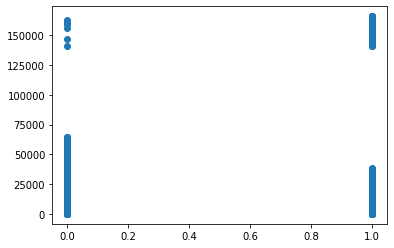

In [62]:
plt.scatter(df['retweet'], df['updates'])
plt.show();

##  Begin to clean and explore your data.

In [0]:
df.isna().sum()

external_author_id         0
author                     0
content                    0
region                   296
language                   0
publish_date               0
harvested_date             0
following                  0
followers                  0
updates                    0
post_type             154277
account_type               0
new_june_2018              0
retweet                    0
account_category           0
dtype: int64

In [59]:
df.describe()

,following,followers,updates,new_june_2018,retweet
count,10646.000000,10646.000000,10646.000000,10646.000000,10646.000000
mean,4288.175465,7153.391978,11428.577964,0.118918,0.407289
std,6429.914395,11896.777084,19320.921093,0.323707,0.491353
min,0.000000,0.000000,1.000000,0.000000,0.000000
25%,668.000000,677.000000,1725.000000,0.000000,0.000000
50%,2125.000000,1885.000000,4809.500000,0.000000,0.000000
75%,5708.000000,12297.000000,14244.000000,0.000000,1.000000
max,76193.000000,144329.000000,166019.000000,1.000000,1.000000


In [58]:
df.describe(exclude='number')

,content,region,language,publish_date,harvested_date,post_type,account_type,account_category
count,10646,10643,10646,10646,10646,4336,10645,10646
unique,10618,16,1,10448,10455,2,16,8
top,#GiftIdeasForPoliticians with this present the...,United States,English,8/15/2017 16:59,8/11/2017 11:12,RETWEET,Right,RightTroll
freq,3,9252,10646,3,3,4159,3533,3539


In [60]:
df['account_type'].value_counts(normalize=True)

Right         0.331893
local         0.211649
left          0.208079
Hashtager     0.112259
news          0.064631
Commercial    0.051292
Russian       0.009770
Koch          0.004227
?             0.002912
German        0.001315
right         0.000564
Italian       0.000564
Arabic        0.000376
ZAPOROSHIA    0.000282
Ebola         0.000094
French        0.000094
Name: account_type, dtype: float64

In [61]:
df['region'].value_counts(normalize=True)
#I might not use region. 

United States           0.869304
Unknown                 0.116602
United Kingdom          0.007329
Azerbaijan              0.003758
Germany                 0.000658
Russian Federation      0.000564
Belarus                 0.000376
Afghanistan             0.000282
Italy                   0.000282
United Arab Emirates    0.000188
Canada                  0.000188
Spain                   0.000094
France                  0.000094
Sweden                  0.000094
Israel                  0.000094
Mexico                  0.000094
Name: region, dtype: float64

## Begin to choose which features, if any, to exclude. Would some features "leak" future information?

In [0]:
#Definitely the features "post_type" would leak because it is most of
#the same information as the target

#I should also exclude external_author_id and author
#I should exclude content unless I want to do some NLP
#or create a new feature like character count
#but with tweets I don't know that that would be useful since
#It's a pretty small number of characters allowed and should thus
#Be fairly uniform 

In [5]:
def wrangle(X):
  X['region'] = X['region'].replace({np.NaN: 'Unknown'})
  
  return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

target = 'retweet'
features = ['region',	'publish_date',	'harvested_date',	
             'following',	'followers',	'updates', 'account_type',	
            	'account_category']

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [6]:
import sklearn as sk
!pip install category_encoders
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.metrics import accuracy_score

In [7]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    RandomForestClassifier(random_state=42, n_jobs=-1)
)
param_distributions = { 
    'randomforestclassifier__max_depth': [20,21,22,23,24,25,26,27,28,29,30], 
    'randomforestclassifier__min_samples_leaf': [10,11,12,13,14,15,16,17,18,19,20]
}


search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=3, 
    scoring='accuracy', 
    verbose=1, 
    return_train_score=True
)

search.fit(X_train, y_train);

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   12.5s finished


In [8]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation Accuracy', -search.best_score_)
pipeline = search.best_estimator_
print("Train Accuracy:", pipeline.score(X_train, y_train))
print("Validation Accuracy:", pipeline.score(X_val, y_val))

Best hyperparameters {'randomforestclassifier__min_samples_leaf': 10, 'randomforestclassifier__max_depth': 24}
Cross-validation Accuracy -0.918407960199005
Train Accuracy: 0.9344705046197583
Validation Accuracy: 0.9185501066098081


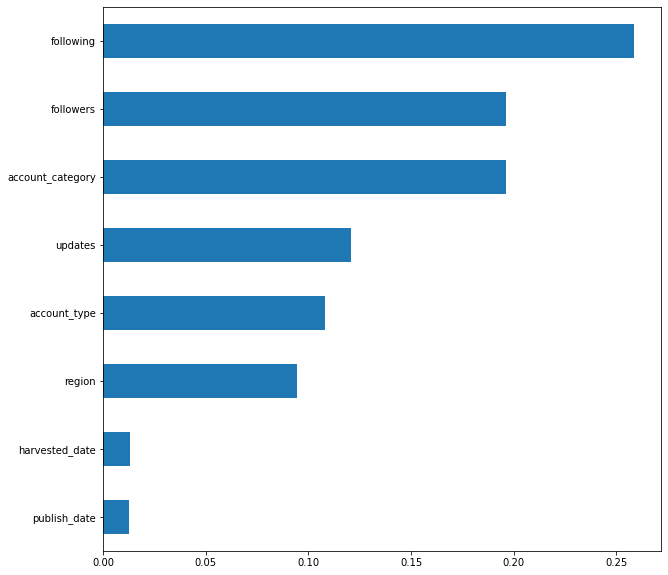

In [15]:
import matplotlib.pyplot as plt
model = pipeline.named_steps['randomforestclassifier']
encoder = pipeline.named_steps['ordinalencoder']
encoded_columns = encoder.transform(X_val).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(10,10))
importances.sort_values().plot.barh();